In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

# Example - System identification with particle MCMC

We are once again looking at the system identification problem, but this time we are going to use a particle MCMC algorithm to estimate the parameters of the system. Let's review the algorithm from the lecture

+ Intialize $\theta^{(0)}$
+ Construct the particle approximation $\{\{(w_t^i, x_t^i)\}_{t=1}^T\}_{i=1}^N$ 
+ For i = 1, .., I:
    + Propose a new parameter $\theta' = q(\theta' | \theta^{(i-1)})$
    + Constuct the particle approximation $\{\{(w_t^i, x_t^i)\}_{t=1}^T \}_{i=1}^N$
    + Compute the acceptance probability

    $$
    \alpha = \min\left(1, \frac{Z' p(\theta')q(\theta^{(i-1)} | \theta')}{\hat{Z}^{(i-1)})p(\theta^{(i-1)})q(\theta' | \theta^{(i-1)})}\right)
    $$

    + Accept $\theta'$ with probability $\alpha$


In [2]:
!pip install diffrax optax blackjax seaborn toml git+https://github.com/PredictiveScienceLab/dax.git

  Cloning https://github.com/PredictiveScienceLab/dax.git to /private/var/folders/cm/5m6g5c890j5cwww5cq4_ydk00000gp/T/pip-req-build-frx3gzyv
  Running command git clone --filter=blob:none --quiet https://github.com/PredictiveScienceLab/dax.git /private/var/folders/cm/5m6g5c890j5cwww5cq4_ydk00000gp/T/pip-req-build-frx3gzyv
  Resolved https://github.com/PredictiveScienceLab/dax.git to commit 022ce93c3ce7929adcbb750ef70d5058b34e8a4b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import time
import jax
import jax.random as jr
import jax.numpy as jnp
import dax

jax.config.update("jax_enable_x64", True)
key = jr.PRNGKey(0)

### Duffing Oscillator

Let's revisit the Duffing Oscillator example.

$$\ddot{x} + \delta \dot{x} + \alpha x + \beta x^3 = \gamma \cos(\omega t) + \sigma \xi(t)$$

The parameters of the system that we will be trying to find are $\theta = [ \alpha, \beta, \delta, \sigma]$.

We will do the usual steps to get the state space representation as we did in the previous notebooks.

In [4]:
# Define the right-hand side, deterministic part of the Duffing oscillator
class DuffingControl(dax.ControlFunction):

    omega: jax.Array

    def __init__(self, omega):
        self.omega = jnp.array(omega)
    
    def _eval(self, t):
        # This is to avoid training the parameter
        omega = jax.lax.stop_gradient(self.omega)
        return jnp.cos(omega * t)

    
class Duffing(dax.StochasticDifferentialEquation):

    alpha: jax.Array
    beta: jax.Array
    delta: jax.Array

    gamma: jax.Array
    log_sigma_x: jax.Array
    log_sigma_v: jax.Array

    @property
    def sigma_x(self):
        return jnp.exp(self.log_sigma_x)

    @property
    def sigma_v(self):
        return jnp.exp(self.log_sigma_v)

    def __init__(self, alpha, beta, gamma, delta, sigma_x, sigma_v, u):
        super().__init__(control_function=u)
        self.alpha = jnp.array(alpha)
        self.beta = jnp.array(beta)
        self.delta = jnp.array(delta)

        self.gamma = jnp.array(gamma)
        self.log_sigma_x = jnp.log(sigma_x)
        self.log_sigma_v = jnp.log(sigma_v)
    
    def drift(self, x, u):
        # We won't train gamma
        gamma = jax.lax.stop_gradient(self.gamma)
        return jnp.array([x[1], -self.delta * x[1] - self.alpha * x[0] - self.beta * x[0] ** 3 + gamma * u])
    
    def diffusion(self, x, u):
        # We won't train sigma_x and sigma_v
        sigma_x = jax.lax.stop_gradient(self.sigma_x)
        sigma_v = jax.lax.stop_gradient(self.sigma_v)
        return jnp.array([sigma_x, sigma_v])

We will first define the true system parameters and generate our noisy data.

In [5]:
# True parameters
omega = 1.2
alpha = -1.0
beta = 1.0
delta = 0.3
gamma = 0.5
sigma_x = 0.01
sigma_v = 0.05
u = DuffingControl(omega)
true_sde = Duffing(alpha, beta, gamma, delta, sigma_x, sigma_v, u)

# True initial conditions
true_x0 = jnp.array([1.0, 0.0])

# Observation model
observation_function = dax.SingleStateSelector(0)
# Observation variance
s = 0.1
true_likelihood = dax.GaussianLikelihood(s, observation_function)

# Generate synthetic data
t0 = 0.0
t1 = 40.0
dt = 0.1
sol = true_sde.sample_path(key, t0, t1, true_x0, dt=dt, dt0=0.05)
key, subkey = jr.split(key)
xs = sol.ys
ts = sol.ts
us = u(ts)
keys = jr.split(key, xs.shape[0])
ys = true_likelihood.sample(xs, us, keys)

# Training data
t_train = 200
ts_train = ts[:t_train]
ts_train_w_init = jnp.concatenate([jnp.array([ts[0] - dt]), ts_train])
ys_train = ys[:t_train]
us_train = us[:t_train]

# Test data
ts_test = ts[t_train-1:-1]
us_test = us[t_train:]

To produce the joint probability density, we will need both our prior and our likelihood as our building blocks. Our prior is just a flat prior over the parameter space. Our likelihood is the same as the EM likelihood, just taken from the log space.

In [6]:
# Prior
class SSMPrior(dax.Prior):
        
        def log_prob(self, ssm):
            # Flat prior over all parameters
            return 0.0

        def sample(self, key):
            return None

# Likelihood
class GaussianLikelihood(dax.Likelihood):

    log_s: jax.Array

    @property
    def s(self):
        return jnp.exp(self.log_s)

    def __init__(self, s):
        self.log_s = jnp.log(s)

    def _log_prob(self, y, x, u):
        return -0.5 * jnp.sum( ((y - x[0]) / self.s) ** 2) - self.log_s
    
    def _sample(self, x, u, key):
        return x[0] + self.s * jr.normal(key, shape=x.shape)

Let's initialize the parameters $\theta^{(0)}$ for our chain to start from. Try adjusting the initial parameters and see how the chain behaves.

In [7]:
# Start a model from the wrong parameters
alpha_0 = -1.5
beta_0 = 1.5
delta_0 = 0.5
s_0 = 1.0

u = DuffingControl(omega)
sde = Duffing(alpha_0, beta_0, gamma, delta_0, sigma_x, sigma_v, s_0)

Now we can construct our state space model, now with the parameters as variables.

In [8]:
# Create a state-space model
ssm = dax.StateSpaceModel(
    dax.DiagonalGaussian(
        jnp.array([0.0, 1.0]),
        jnp.array([2.0, 2.0])),
    dax.EulerMaruyama(sde, dt=dt),
    GaussianLikelihood(s_0)
)

# Place the parameters in a dictionary
theta = {
    'alpha': alpha_0,
    'beta': beta_0,
    'delta': delta_0,
    'log_s': jnp.log(s_0),
    'x0': {
        'mean': jnp.array([0.0, 0.0]),
        'log_sigma': jnp.array([1.0, 1.0])
    }
}

# Create a state-space model from the parameters
def ssm_from_theta(theta):
    return dax.StateSpaceModel(
        dax.DiagonalGaussian(
            theta['x0']['mean'],
            jnp.exp(theta['x0']['log_sigma'])),
        dax.EulerMaruyama(Duffing(theta['alpha'], theta['beta'], gamma, theta['delta'], sigma_x, sigma_v, u), dt=dt),
        GaussianLikelihood(jnp.exp(theta['log_s']))
    )


Okay, now we are set up to run our MCMC algorithm. Feel free to play around with the hyperparameters to get a better fit.

In [9]:
# Particle MCMC hyperparameters
num_particles = 1000
proposal_scale = 0.01
num_iters = 10000

prior = SSMPrior()
filter = dax.BootstrapFilter(num_particles=num_particles)
mcmc = dax.ParticleMCMC(prior, filter, proposal_scale, ssm_from_theta)

print('Running MCMC...')

# Track the amount of time it takes to run the MCMC
mcmc_start = time.time()

state = (theta, filter.filter(ssm_from_theta(theta), us_train, ys_train, key)[1], 0.0, key, us_train, ys_train)
theta, (accept, log_Ls, thetas) = mcmc.run(theta, us_train, ys_train, num_iters, key)

mcmc_end = time.time()

print(f'MCMC took {mcmc_end - mcmc_start:.2f} seconds')

Running MCMC...
MCMC took 381.48 seconds


Let's take a look at our likelihood evolution as we ran the MCMC algorithm to check for convergence.

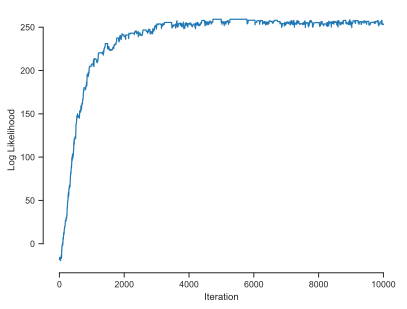

In [10]:
fig, ax = plt.subplots()
ax.plot(log_Ls)
ax.set_xlabel('Iteration')
ax.set_ylabel('Log Likelihood')
sns.despine(trim=True)
plt.show()

We can see how our chain evolved over the iterations and see how it moves around in the parameter space.

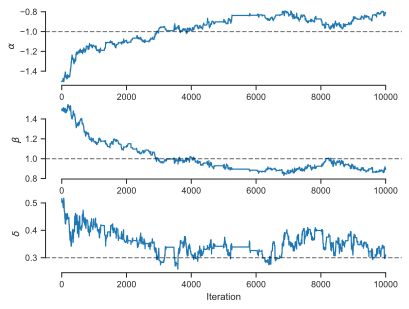

In [11]:
fig, ax = plt.subplots(3, 1)

ax[0].plot(thetas['alpha'])
ax[0].axhline(alpha, color='black', linestyle='--', alpha=0.5)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel(r'$\alpha$')

ax[1].plot(thetas['beta'])
ax[1].axhline(beta, color='black', linestyle='--', alpha=0.5)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel(r'$\beta$')

ax[2].plot(thetas['delta'])
ax[2].axhline(delta, color='black', linestyle='--', alpha=0.5)
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel(r'$\delta$')

sns.despine(trim=True)
plt.show()

The goal of particle MCMC, to estimate the posterior distribution of the parameters, is achieved. We can plot the histogram of the parameters to visualize our posterior.

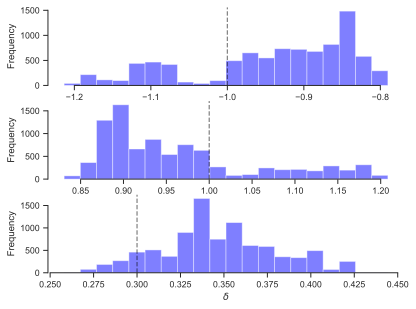

In [12]:
# Do the histograms of the parameters
skip = int(num_iters / 10)
alpha_keep = thetas['alpha'][skip:]
beta_keep = thetas['beta'][skip:]
delta_keep = thetas['delta'][skip:]

fig, ax = plt.subplots(3, 1)

ax[0].hist(alpha_keep, bins=20, color='blue', alpha=0.5)
ax[0].axvline(alpha, color='black', linestyle='--', alpha=0.5)
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Frequency')

ax[1].hist(beta_keep, bins=20, color='blue', alpha=0.5)
ax[1].axvline(beta, color='black', linestyle='--', alpha=0.5)
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Frequency')

ax[2].hist(delta_keep, bins=20, color='blue', alpha=0.5)
ax[2].axvline(delta, color='black', linestyle='--', alpha=0.5)
ax[2].set_xlabel(r'$\delta$')
ax[2].set_ylabel('Frequency')

sns.despine(trim=True)
plt.show()

Not amazing, but the true paramaters are in the range of the posterior distribution.

We can see how computationally expensive particle MCMC is compared to the EM algorithm. However, it is a powerful tool to estimate the posterior distribution of the parameters. Try to play around with the hyperparameters to balance a good fit and computational cost. Do you think this system is identifiable?